source：https://github.com/AlexLynd/ESP8266-Wardriving

the dataset: gathered the data by walking around with WiGLE, exported to csv

the task: filter data by different criteria, plot on the map

In [ ]:
import numpy as np
import pandas as pd
import folium
from folium import Map, Marker
import random
import matplotlib.pyplot as plt
color_list = ['black', 'darkblue', 'cadetblue', 'pink', 'darkred', 'white', 'orange', 'purple', 'lightblue', 'darkpurple', 'gray', 'red', 'lightgray', 'lightred', 'green', 'darkgreen', 'beige', 'lightgreen', 'blue']


In [ ]:
def importdataset():
    global wd
    wd = pd.read_csv ('WigleWifi_20210906181508.csv', skiprows=1) 
    print(f"total devices: {len(wd)}") # number of detected devices

# explore and clean the data

In [ ]:
importdataset()
wd.sample(5)

In [ ]:
wd["MAC"].value_counts()

In [ ]:
#take a look how many unique valid MACs are there and how many entries in total
wd.loc[(wd['MAC'].str.len() == 17)]["MAC"].describe()

In [ ]:
print(f"number of unique APs: {len(wd['MAC'].unique())}")

# plot all WCDMA towers

In [ ]:
importdataset()
wd.sample(5)

In [ ]:
# drop all else except WCDMA
wd = pd.DataFrame( wd.loc[wd['Type'] == "WCDMA"] )
wd = wd.reset_index(drop=True)
wd.sample(5)

In [ ]:
wd['MAC'].value_counts()

In [ ]:
#color code different MACs
wd["Color"] = None
for index, row in wd.iterrows():
    if wd['Color'][index] == None:
        wd.loc[wd['MAC'] == wd['MAC'][index],"Color"] = random.choice(color_list)

In [ ]:
pd.DataFrame (wd, columns=['Color','MAC']).value_counts()

In [ ]:
lat = wd["CurrentLatitude"][0]
lon = wd["CurrentLongitude"][0]
basic_map = folium.Map(location=[lat, lon],zoom_start=17) # manually pick scope of map

# folium.PolyLine(wd[['CurrentLatitude', 'CurrentLongitude']].values.tolist(),line_opacity = 0.5, weight = 4).add_to(basic_map) # plot route

# add markers for every point in dataset 
for i in range(len(wd)): 
#     if wd["FirstSeen"][i] > "2021-8-21 18:43:25" and wd["FirstSeen"][i] < "2021-8-21 18:46:58": # add time filter
#     if wd["RSSI"][i] > 10:
    if wd.loc[wd['MAC'] == wd['MAC'][i],"RSSI"].max() == wd["RSSI"][i]:# only plot with highest signal strength
        lat = wd["CurrentLatitude"][i]
        lon = wd["CurrentLongitude"][i] 
        folium.Marker( location=[lat, lon], tooltip=f'MAC {wd["MAC"][i]}, strength {wd["RSSI"][i]}', icon=folium.Icon(icon="wifi", color=wd["Color"][i], prefix='fa') ).add_to(basic_map) # annotate GPS location w/ SSID
print(f"total towers: {len(wd['MAC'].unique())}")        
display(basic_map)

# 

# 

# 

# plot all WIFI APs with highest signal strength

In [ ]:
importdataset()
wd.sample(5)

In [ ]:
#drop everything except those having valid MACs
wd = wd.loc[(wd['MAC'].str.len() == 17)]
wd = wd.reset_index(drop=True)
wd.sample(5)

In [ ]:
wd.info()

In [ ]:
print(f"total APs: {len(wd['MAC'].unique())}") 

In [ ]:
lat = wd["CurrentLatitude"][0]
lon = wd["CurrentLongitude"][0]
basic_map = folium.Map(location=[lat, lon],zoom_start=17) # manually pick scope of map

# add markers for every point in dataset 
for i in range(len(wd)): 
    if wd.loc[wd['SSID'] == wd['SSID'][i],"RSSI"].max() == wd["RSSI"][i]: # only plot AP with highest signal strength
        lat = wd["CurrentLatitude"][i]
        lon = wd["CurrentLongitude"][i]
        folium.Marker( location=[lat, lon], tooltip=f'SSID {wd["SSID"][i]}, strength {wd["RSSI"][i]}', icon=folium.Icon(icon="wifi", color="blue", prefix='fa') ).add_to(basic_map) # annotate GPS location w/ SSID
print(f"total APs: {len(wd['MAC'].unique())}")    
display(basic_map)

# 

# 

# 

# 

# plot all WPS-enabled wifi with highest signal strength

In [ ]:
importdataset()
wd.sample(5)

In [ ]:
wd['AuthMode'].value_counts()

In [ ]:
# make a sorted list of authmodes used
wd_sorted_list = pd.DataFrame (wd, columns=['AuthMode']).value_counts().rename_axis('Auth_sorted').reset_index(name='counts')
wd_sorted_list

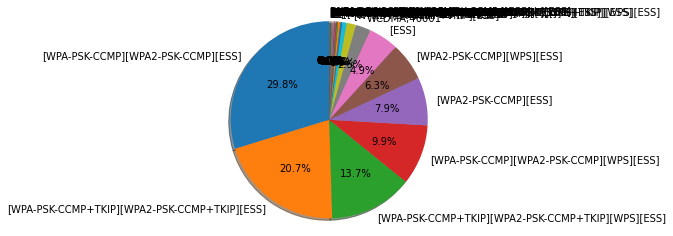

In [56]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = wd_sorted_list['Auth_sorted']
sizes = wd_sorted_list['counts']

fig1, ax1 = plt.subplots()
ax1.pie(sizes,  labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

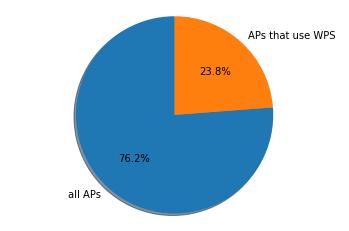

In [57]:
ap_total=len(wd)
ap_use_wps=len(pd.DataFrame( wd.loc[lambda x: (wd['AuthMode'].str.find('WPS') != -1), :]))
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = "all APs", "APs that use WPS"
sizes = [ap_total, ap_use_wps]

fig1, ax1 = plt.subplots()
ax1.pie(sizes,  labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [ ]:
# drop all except those that use WPS
wd = pd.DataFrame( wd.loc[lambda x: (wd['AuthMode'].str.find('WPS') != -1), :])
wd = wd.reset_index(drop=True)
wd.sample(5)

In [59]:
wd['AuthMode'].value_counts()

[WPA-PSK-CCMP+TKIP][WPA2-PSK-CCMP+TKIP][WPS][ESS]           2016
[WPA-PSK-CCMP][WPA2-PSK-CCMP][WPS][ESS]                     1460
[WPA2-PSK-CCMP][WPS][ESS]                                    921
[WPS][ESS]                                                   103
[WPA2-PSK-CCMP][WPS][ESS][P2P]                                50
[WPA-PSK-TKIP][WPA2-PSK-CCMP][WPS][ESS]                       23
[WPA-PSK-CCMP][WPS][ESS]                                       7
[WPA2-PSK-CCMP+TKIP][WPS][ESS]                                 5
[WPA-PSK-CCMP+TKIP][WPS][ESS]                                  4
[WPA2-PSK-CCMP][WPS-AUTH][ESS]                                 3
[WPA-PSK-CCMP][WPA2-PSK+FT/PSK-CCMP][WPS][ESS]                 2
[WPA2-PSK-CCMP][WPS-PBC][ESS][P2P]                             1
[WPA-PSK-CCMP+TKIP][WPA2-PSK+FT/PSK-CCMP+TKIP][WPS][ESS]       1
Name: AuthMode, dtype: int64

In [60]:
# make a sorted list of authmodes used
wd_sorted_list = pd.DataFrame (wd, columns=['AuthMode']).value_counts().rename_axis('Auth_sorted').reset_index(name='counts')
wd_sorted_list

,Auth_sorted,counts
0,[WPA-PSK-CCMP+TKIP][WPA2-PSK-CCMP+TKIP][WPS][ESS],2016
1,[WPA-PSK-CCMP][WPA2-PSK-CCMP][WPS][ESS],1460
2,[WPA2-PSK-CCMP][WPS][ESS],921
3,[WPS][ESS],103
4,[WPA2-PSK-CCMP][WPS][ESS][P2P],50
5,[WPA-PSK-TKIP][WPA2-PSK-CCMP][WPS][ESS],23
6,[WPA-PSK-CCMP][WPS][ESS],7
7,[WPA2-PSK-CCMP+TKIP][WPS][ESS],5
8,[WPA-PSK-CCMP+TKIP][WPS][ESS],4
9,[WPA2-PSK-CCMP][WPS-AUTH][ESS],3


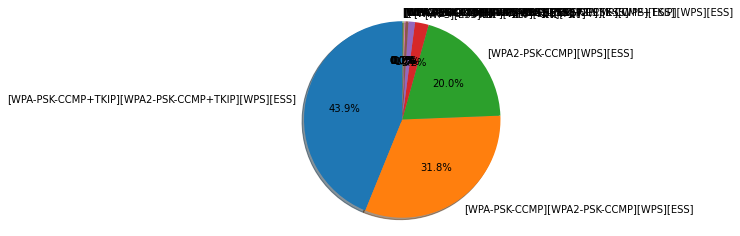

In [61]:
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = wd_sorted_list['Auth_sorted']
sizes = wd_sorted_list['counts']

fig1, ax1 = plt.subplots()
ax1.pie(sizes,  labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [ ]:
#color code authmodes
wd["Color"] = None
for index, row in wd.iterrows():
    if wd['Color'][index] == None:
        wd.loc[wd['AuthMode'] == wd['AuthMode'][index],"Color"] = random.choice(color_list)

In [ ]:
pd.DataFrame (wd, columns=['Color','AuthMode']).value_counts()

In [ ]:
lat = wd["CurrentLatitude"][0]
lon = wd["CurrentLongitude"][0]
basic_map = folium.Map(location=[lat, lon],zoom_start=17) # manually pick scope of map

# add markers for every point in dataset 
for i in range(len(wd)): 

    if wd.loc[wd['SSID'] == wd['SSID'][i],"RSSI"].max() == wd["RSSI"][i]: # only plot AP with highest signal strength
        lat = wd["CurrentLatitude"][i]
        lon = wd["CurrentLongitude"][i]
        folium.Marker( location=[lat, lon], tooltip=f'SSID {wd["SSID"][i]}, strength {wd["RSSI"][i]}', icon=folium.Icon(icon="wifi", color=wd["Color"][i], prefix='fa') ).add_to(basic_map) # annotate GPS location w/ SSID
print(f"total APs: {len(wd['MAC'].unique())}")    
display(basic_map)

# add vendor names to the dataset

In [ ]:
mac_vendors = pd.read_csv ('mac-vendors.csv', names=("MAC", "Vendor")) 
mac_vendors["MAC"]= mac_vendors["MAC"].str.lower()
mac_vendors

In [63]:
importdataset()

total devices: 14729


In [ ]:
mac_vendors.loc[mac_vendors['MAC'] == wd['MAC'][0][:8],"Vendor"]

In [65]:
wd['Vendor'] = None
for index, row in wd.iterrows():
    if wd['Vendor'][index] == None:
        if len(mac_vendors.loc[mac_vendors['MAC'] == row['MAC'][:8],"Vendor"]) >0: #if there's a match
            wd["Vendor"][index] = mac_vendors.loc[mac_vendors['MAC'] == row['MAC'][:8],"Vendor"].values[0]
            


/var/folders/cl/c06_nmsn3vv83hvd_tpcfr100000gn/T/ipykernel_24497/2565584916.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wd["Vendor"][index] = mac_vendors.loc[mac_vendors['MAC'] == row['MAC'][:8],"Vendor"].values[0]


In [66]:
wd.isna().sum()

MAC                     0
SSID                  101
AuthMode                0
FirstSeen               0
Channel                 0
RSSI                    0
CurrentLatitude         0
CurrentLongitude        0
AltitudeMeters          0
AccuracyMeters          0
Type                    0
Vendor              10649
dtype: int64

In [67]:
wd["Vendor"].value_counts()

TP-LINK TECHNOLOGIES CO.,LTD.                    1162
Shenzhen Sundray Technologies Company Limited     459
HUAWEI TECHNOLOGIES CO.,LTD                       292
Tenda Technology Co.,Ltd.Dongguan branch          273
Phicomm (Shanghai) Co., Ltd.                      177
                                                 ... 
Texas Instruments                                   1
Beijing LT Honway Technology Co.,Ltd                1
Rebound Telecom. Co., Ltd                           1
STRAND LIGHTING LIMITED                             1
China Mobile IOT Company Limited                    1
Name: Vendor, Length: 115, dtype: int64

In [ ]:
# 